Testing SVD Impact on Averaged Noise Correlation Functions from DAS Data

In [ ]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.signal as sig
import scipy.fft as ft
import scipy.linalg as la
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

Downloading DAS files from flashdrive:

In [ ]:
prefix = '/Volumes/Big_USB/Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-06-27T180'
postfix = '53Z.h5'
nfiles = 10
files0 = [prefix+str(i)+postfix for i in range(nfiles)]

prefix = '/Volumes/Big_USB/Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-06-27T181'
files1 = [prefix+str(i)+postfix for i in range(nfiles)]

prefix = '/Volumes/Big_USB/Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-06-27T182'
files2 = [prefix+str(i)+postfix for i in range(nfiles)]

prefix = '/Volumes/Big_Boi/Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-06-27T183'
files3 = [prefix+str(i)+postfix for i in range(nfiles)]

prefix = '/Volumes/Big_Boi/Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-06-27T184'
files4 = [prefix+str(i)+postfix for i in range(nfiles)]

prefix = '/Volumes/Big_Boi/Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-06-27T185'
files5 = [prefix+str(i)+postfix for i in range(nfiles)]

#checking the files are there 
for f in files5:
    print(f, 'exists:', os.path.exists(f))

In [43]:
#looks at first file in read mode to see what the top level groups are
#the following 10 or so cells are trying to find out what kind of data set this is 
f = h5py.File(files5[0], 'r')
list(f.keys())

['Acquisition']

In [ ]:

# list(f['Acquisition'])  lkn;lkj

['Custom', 'Raw[0]']

In [13]:

print(f['Acquisition'].values)

<bound method MappingHDF5.values of <HDF5 group "/Acquisition" (2 members)>>


In [14]:
list(f['Acquisition']['Raw[0]'])

['Custom', 'RawData', 'RawDataTime']

In [15]:
list(f['Acquisition']['Raw[0]']['Custom'])

['GpBits', 'GpsStatus', 'PpsOffset', 'SampleCount']

In [16]:
type(f['Acquisition']['Raw[0]']['RawDataTime'])

h5py._hl.dataset.Dataset

In [17]:
f['Acquisition']['Raw[0]']['RawDataTime'].shape

(30000,)

In [18]:
f['Acquisition']['Raw[0]']['RawDataTime'][:]

array([1687888853373200, 1687888853375200, 1687888853377200, ...,
       1687888913367200, 1687888913369200, 1687888913371200])

In [19]:
type(f['Acquisition']['Raw[0]']['RawData'])

h5py._hl.dataset.Dataset

In [44]:
data = f['Acquisition']['Raw[0]']['RawData']

In [21]:
# data0 = []
# for i in range(len(files0)):
#     f = h5py.File(files0[i], 'r')
#     data = f['Acquisition']['Raw[0]']['RawData']
#     data0.append(data0)


In [ ]:
vmax = np.percentile(np.absolute(data),90)
plt.imshow(data,aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('30s of Raw data for channe')


Text(0.5, 0, 'Channel')

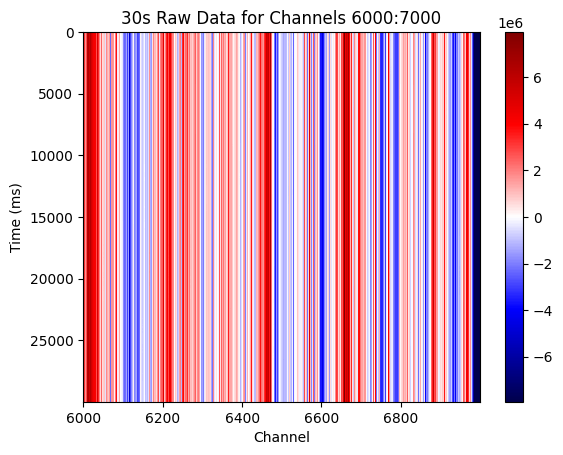

In [ ]:
vmax = np.percentile(np.absolute(data[:,6000:7000]),97)
plt.imshow(data[:,6000:7000],aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('30s Raw Data for Channels 6000:7000')
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.ylabel('Time (ms)')
plt.xlabel('Channel')

compute strainrate

In [14]:
dt = 1.0/500.0 
strainrate = (data[1:,:]-data[:-1,:])/dt

# vmax = np.percentile(np.absolute(strainrate),97)
# plt.imshow(strainrate,aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
# plt.colorbar()
# plt.title('30s Strainrate for Channels 6000:7000')
# plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
# plt.ylabel('Time (ms)')
# plt.xlabel('Channel')

Text(0.5, 0, 'Channel')

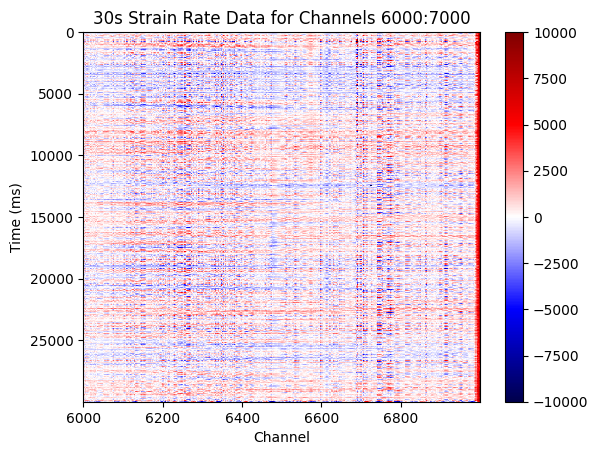

In [ ]:
# vmax = np.percentile(np.absolute(strainrate[:,6000:7000]),10)
vmax = 10000
plt.imshow(strainrate[:,6000:7000],aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('30s Strain Rate Data for Channels 6000:7000')
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.ylabel('Time (ms)')
plt.xlabel('Channel')

In [ ]:
print(data.shape)


(30000, 7020)


In [ ]:
#demeaned strain rate
demeaned_strainrate = strainrate - np.mean(strainrate, axis=0)

Text(0.5, 0, 'Channel')

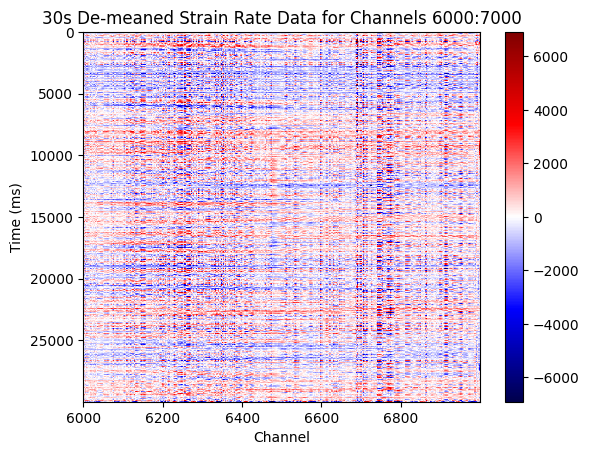

In [ ]:
# vmax = 100
vmax = np.percentile(np.absolute(demeaned_strainrate[:,6000:7000]),5)
plt.imshow(demeaned_strainrate[:,6000:7000],aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('30s De-meaned Strain Rate Data for Channels 6000:7000')
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.ylabel('Time (ms)')
plt.xlabel('Channel')


In [15]:
nt = strainrate.shape[0]
nch = strainrate.shape[1]

In [15]:
def freq_domain_bandpass(data, fs, lowcut, highcut):
    """
    Apply a bandpass filter in the frequency domain.

    Parameters:
        data: 2D NumPy array (time × channels)
        fs: Sampling frequency in Hz
        lowcut: Lower frequency in Hz
        highcut: Upper frequency in Hz

    Returns:
        Bandpass-filtered data (same shape)
    """
    n_samples, n_channels = data.shape
    freqs = np.fft.rfftfreq(n_samples, d=1/fs)  # one-sided freq axis
    fft_data = np.fft.rfft(data, axis=0)        # FFT along time axis

    # Create frequency mask
    bandpass_mask = (freqs >= lowcut) & (freqs <= highcut)
    fft_data[~bandpass_mask, :] = 0             # zero out unwanted freqs

    # Inverse FFT to time domain
    filtered = np.fft.irfft(fft_data, n=n_samples, axis=0)
    return filtered



In [ ]:
fs = 1000       # Hz
lowcut = 1.0    # Hz
highcut = 500.0  # Hz

filtered = freq_domain_bandpass(demeaned_strainrate, fs, lowcut, highcut)

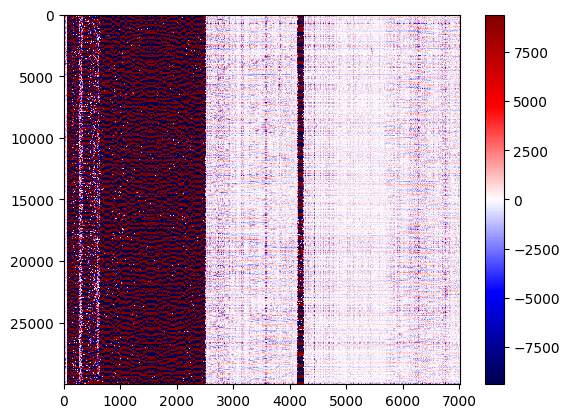

In [ ]:
vmax = np.percentile(np.absolute(filtered),5)
plt.imshow(filtered,aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()

Text(0.5, 0, 'Channel')

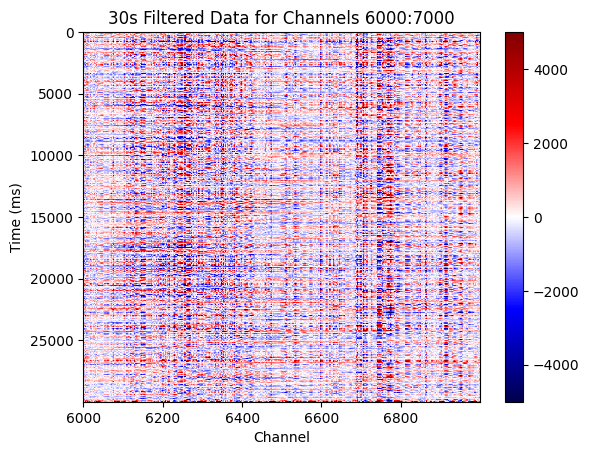

In [ ]:
# vmax = np.percentile(np.absolute(filtered[:,6000:7000]),95)
vmax = 5000
plt.imshow(filtered[:,6000:7000],aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('30s Filtered Data for Channels 6000:7000')
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.ylabel('Time (ms)')
plt.xlabel('Channel')

(7020,)


Text(0.5, 0, 'Channel')

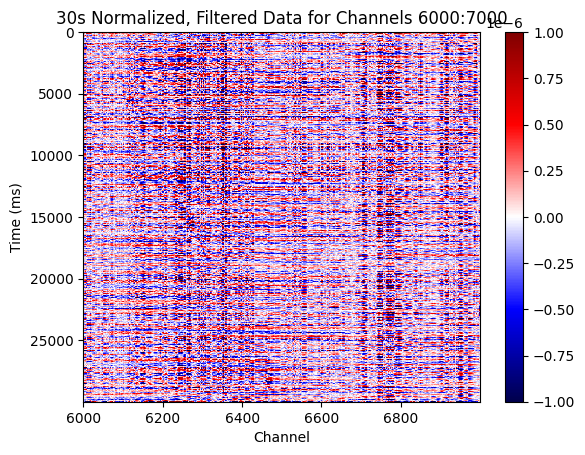

In [ ]:
factor = np.linalg.norm(filtered, ord=1, axis=0)
print(factor.shape)
normalized = filtered / factor

# vmax = np.percentile(np.absolute(normalized),90)
vmax = 0.000001
plt.imshow(normalized[:,6000:7000],aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('30s Normalized, Filtered Data for Channels 6000:7000')
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.ylabel('Time (ms)')
plt.xlabel('Channel')

Text(0.5, 1.0, 'smaller section')

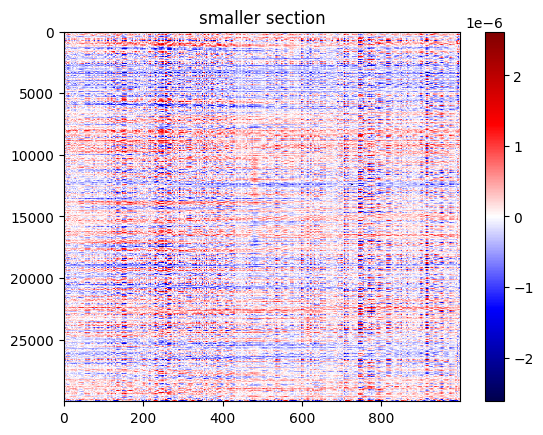

In [ ]:
# vmax = 0.000001
vmax = np.percentile(np.absolute(normalized[:,6000:7000]),5)
plt.imshow(normalized[:,6000:7000],aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('smaller section')

In [ ]:
startCh = 6000
endCh = 7000
dataOfInterest = normalized[:,startCh:endCh]

# vmax = np.percentile(np.absolute(dataOfInterest),10)
# vmax = 0.000001
# plt.imshow(dataOfInterest,aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
# plt.colorbar()
# plt.title('30s PreProcessed Data for Channels 6000:7000')
# plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
# plt.ylabel('Time (ms)')
# plt.xlabel('Channels')

Text(0.5, 0, 'Channel')

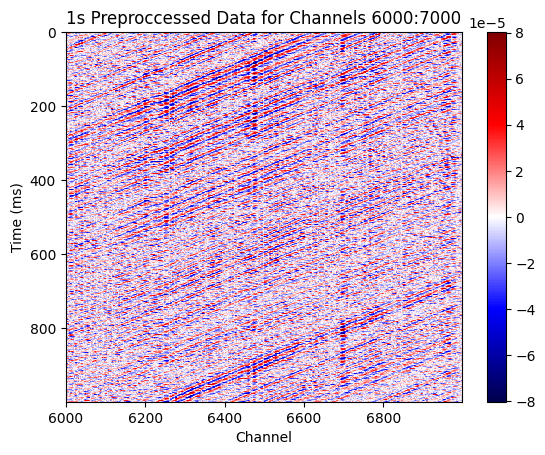

In [ ]:
vmax = np.percentile(np.absolute(dataOfInterest[:1000,:]),95)
plt.imshow(dataOfInterest[:1000,:],aspect='auto',vmin=-vmax,vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('1s Preproccessed Data for Channels 6000:7000')
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.ylabel('Time (ms)')
plt.xlabel('Channel')

In [45]:
# Do all the pre processing 
dt = 1.0/500.0 

startCh = 6000
endCh = 7000
nfiles = 10

fs = 1000       # Hz
lowcut = 1.0    # Hz
highcut = 500.0  # Hz
processed_data = []

for i in range(nfiles):
    print (i) # to keep track of progress

     # read file's data
    f = h5py.File(files5[i], 'r')
    data = f['Acquisition']['Raw[0]']['RawData']
    

    # window on start and end channel, get strain rate and normalize
    strainrate = (data[1:,startCh:endCh]-data[:-1,startCh:endCh])/dt
    # demean
    demeaned_strainrate = strainrate - np.mean(strainrate, axis=0)   
    # filter
    filtered = freq_domain_bandpass(demeaned_strainrate, fs, lowcut, highcut)
    # normalize
    norms = la.norm(filtered,axis=0)
    processed = filtered/norms

    processed_data.append(processed)
    


0
1
2
3
4
5
6
7
8
9


In [46]:
dt = 1.0/1000.0
sampleRate = int(1/dt)
nWindowsPerFile = 6
secondsPerFile = 30.0
startCh = 6000
vsCh = 50 # virtual source
endCh = 7000
secondsLag = 1.0
nfiles = 10

# original crosscorrelations
xcorrs = np.zeros((2*sampleRate*int(secondsPerFile/nWindowsPerFile) - 1,endCh-startCh))
# svd crosscorrelations
svdxcorrs = np.zeros((2*sampleRate*int(secondsPerFile/nWindowsPerFile) - 1,endCh-startCh))

# to track differences in data and differences in cross-correlations
dataNorm = np.zeros(nfiles*(nWindowsPerFile-1))
dataDiffNorm = np.zeros(nfiles*(nWindowsPerFile-1))
winCtr = 0

for i in range(nfiles):
    print(i) # to keep track of progress
    
    # read file's data
    # f = h5py.File(files[i], 'r')
    # data = f['Acquisition']['Raw[0]']['RawData']
    
    # # window on start and end channel, get strain rate and normalize
    # strainrate = (data[1:,startCh:endCh]-data[:-1,startCh:endCh])/dt
    # # normalize
    # strainrateNorms = la.norm(strainrate,axis=0)
    # strainrate = strainrate/strainrateNorms
    # one bit normalize
    #strainrate[strainrate>0] = 1
    #strainrate[strainrate<0] = -1


    # calculate xcorr
    for subwin in range(nWindowsPerFile-1):
        
        startID = sampleRate*int(subwin*np.floor(secondsPerFile/nWindowsPerFile))
        endID = sampleRate*int((subwin+1)*np.floor(secondsPerFile/nWindowsPerFile))

        # original crosscorrs
        theseData = processed_data[i][startID:endID,:]
        dataNorm[winCtr] = la.norm(theseData,ord='fro')
        vs = theseData[:,vsCh]
        for ch in range(1000):
            xcorrs[:,ch] = xcorrs[:,ch] + sig.correlate(vs,theseData[:,ch],method='fft')

        # SVD crosscorrs
        (U,s,Vh) = la.svd(theseData)

        # s_diag = np.diag(s)
        # #"Find number of singluar values to retain "50%, 70%, 90%" of image" Pank's words
        # s2 = np.square(s)
        #10%
        length = len(s)
        k = int(length/10) #trunc[2]#sings_choosefrom[3] #the truncation you want - 75% is 0
        # totvar = np.sum(s2)
        # percentkept = np.sum(s2[0:k])/totvar

        # k = 30 # truncated rank
        Utrunc = U[:,:k]
        strunc = s[:k]
        Vhtrunc = Vh[:k,:]
        reconData = Utrunc @ np.diag(strunc) @ Vhtrunc
        dataDiffNorm = la.norm(theseData-reconData,ord='fro')
        vsrec = reconData[:,vsCh]
        for ch in range(1000):
            svdxcorrs[:,ch] = svdxcorrs[:,ch] + sig.correlate(vsrec,reconData[:,ch],method='fft')

        winCtr = winCtr+1

0
1
2
3
4
5
6
7
8
9


In [47]:
# np.save('/Volumes/Big_boi/processed_data5.npy', processed_data)
np.save('/Volumes/Big_boi/xc0.npy', xcorrs)
np.save('/Volumes/Big_boi/svdxc0.npy', svdxcorrs)

Text(0.5, 0, 'Channel Distance (m)')

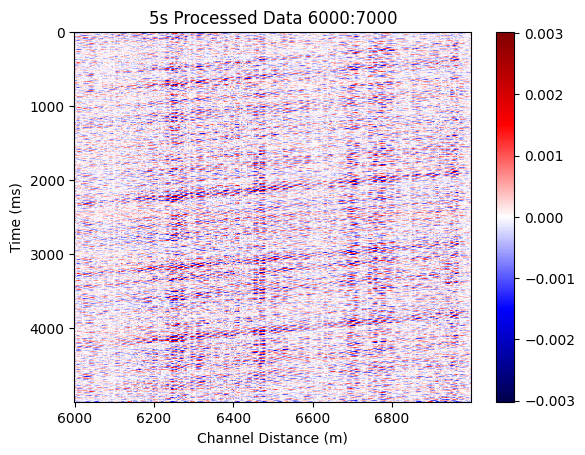

In [12]:
processed_data = np.array(processed_data)
vmax=np.percentile(np.absolute(processed_data[0:5000,:]),40)
plt.imshow(processed_data[9][:5000,:],aspect='auto',vmin=-vmax, vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('5s Processed Data 6000:7000')
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.ylabel('Time (ms)')
plt.xlabel('Channel Distance (m)')

Text(0.5, 0, 'Channel Distance (m)')

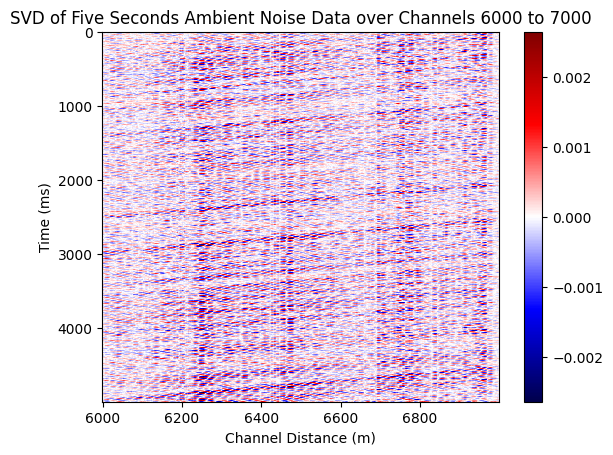

In [7]:
plt.clf()
vmax=np.percentile(np.absolute(reconData),40)
plt.imshow(reconData,aspect='auto',vmin=-vmax, vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('SVD of Five Seconds Ambient Noise Data over Channels 6000 to 7000')

plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.ylabel('Time (ms)')
plt.xlabel('Channel Distance (m)')


In [38]:
# import numpy as np

A = processed[:5000,:]
Ak = reconData
fro_norm_diff = np.linalg.norm(A - Ak, 'fro')
fro_norm_orig = np.linalg.norm(A, 'fro')

relative_error = fro_norm_diff / fro_norm_orig
print(f"Relative Frobenius norm error: {relative_error}")

Relative Frobenius norm error: 1.3422435295545339


In [16]:
s_diag = np.diag(s)
        # #"Find number of singluar values to retain "50%, 70%, 90%" of image" Pank's words
s2 = np.square(s)
print(s2)

[4.75201942e+00 4.16980772e+00 3.90148025e+00 3.55264703e+00
 3.21192518e+00 2.87252146e+00 2.70994167e+00 2.37516730e+00
 2.32808940e+00 2.27676677e+00 2.06219279e+00 2.02335500e+00
 1.96995330e+00 1.90217491e+00 1.87459609e+00 1.82224244e+00
 1.76961774e+00 1.75361635e+00 1.71727647e+00 1.68250565e+00
 1.64337927e+00 1.62608617e+00 1.61162163e+00 1.59124901e+00
 1.57031684e+00 1.56576130e+00 1.53358419e+00 1.52126392e+00
 1.50168585e+00 1.47766554e+00 1.46705641e+00 1.44040003e+00
 1.41180200e+00 1.39549513e+00 1.36659781e+00 1.35614312e+00
 1.35262367e+00 1.34008769e+00 1.31997737e+00 1.29911636e+00
 1.27688128e+00 1.26816862e+00 1.24209520e+00 1.23488491e+00
 1.22818221e+00 1.21576284e+00 1.19930883e+00 1.18781889e+00
 1.18153445e+00 1.15618992e+00 1.14670371e+00 1.13931098e+00
 1.13244731e+00 1.11735826e+00 1.10182599e+00 1.09685091e+00
 1.07850018e+00 1.06720659e+00 1.05323456e+00 1.04865478e+00
 1.03421704e+00 1.02254592e+00 1.01058441e+00 9.97414441e-01
 9.91290254e-01 9.769756

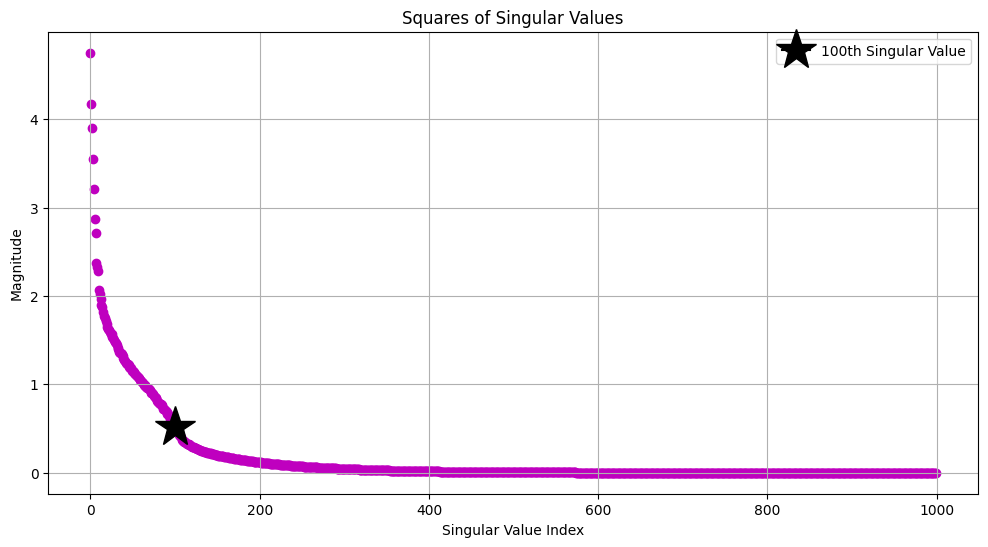

In [33]:

plt.figure(figsize=(12, 6))
plt.scatter(range(len(s2)), s2, color='m', marker='o')  # Just dots
plt.plot(100,s2[100],  'k', markersize=30, marker='*', label='100th Singular Value')
plt.xlabel('Singular Value Index')
plt.ylabel('Magnitude')
plt.title('Squares of Singular Values')
plt.grid(True)
# plt.tight_layout()
plt.legend()
plt.show()

In [7]:
np.save('/Volumes/Big_boi/processed_data5.npy', processed_data)
np.save('/Volumes/Big_boi/xcorrs5.npy', xcorrs)
np.save('/Volumes/Big_boi/svdxcorrs5.npy', svdxcorrs)

In [5]:
xcorrs0 = np.load('/Volumes/Big_USB/xc0.npy')
svdxcorrs0 = np.load('/Volumes/Big_USB/SVDxc0.npy')
xcorrs1 = np.load('/Volumes/Big_USB/xc1.npy')
svdxcorrs1 = np.load('/Volumes/Big_USB/SVDxc1.npy')
xcorrs2 = np.load('/Volumes/Big_USB/xc2.npy')
svdxcorrs2 = np.load('/Volumes/Big_USB/SVDxc2.npy')
xcorrs3 = np.load('/Volumes/Big_USB/xc3.npy')
svdxcorrs3 = np.load('/Volumes/Big_USB/SVDxc3.npy')
xcorrs4 = np.load('/Volumes/Big_USB/xc4.npy')
svdxcorrs4 = np.load('/Volumes/Big_USB/SVDxc4.npy')
xcorrs5 = np.load('/Volumes/Big_USB/xc5.npy')
svdxcorrs5 = np.load('/Volumes/Big_USB/SVDxc5.npy')
xcorrs = xcorrs0+xcorrs1+xcorrs2+xcorrs3+xcorrs4+xcorrs5
svdxcorrs = svdxcorrs0+svdxcorrs1+svdxcorrs2+svdxcorrs3+svdxcorrs4+svdxcorrs5

Average relative error: 0.45735737124851006


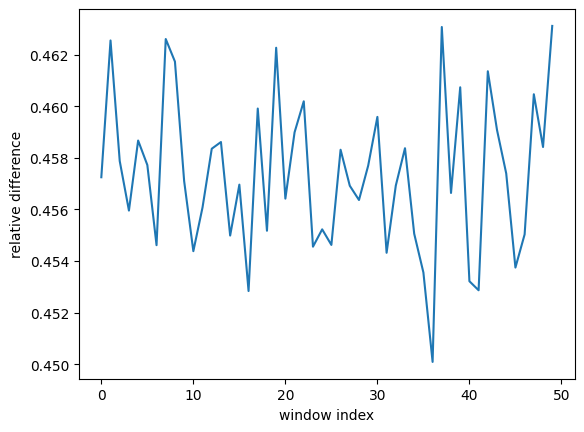

In [23]:
plt.plot(dataDiffNorm/dataNorm)
plt.xlabel('window index')
plt.ylabel('relative difference')


print("Average relative error: "+str(np.mean(dataDiffNorm/dataNorm)))

In [ ]:
xcorrs = xc0+xc1+xc2+xc3+xc4+xc5
svdxcorrs = svdxc0+svdxc1+svdxc2+svdxc3+svdxc4+svdxc5

Text(0.5, 0, 'Channel number')

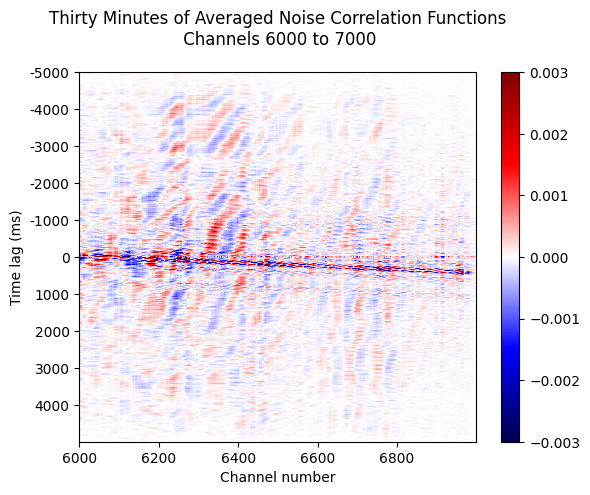

In [54]:
plt.clf()
# vmax=np.percentile(np.absolute(xcorrs0[:,:]),30)
vmax = 0.003
plt.imshow(xcorrs[:,:]/6,aspect='auto',vmin=-vmax, vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('Thirty Minutes of Averaged Noise Correlation Functions\n Channels 6000 to 7000',pad=20)
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.yticks(np.arange(0, 10000,step = 1000), labels=np.arange(-5000, 5000, step=1000))
plt.ylabel('Time lag (ms)')
plt.xlabel('Channel number')

Text(0.5, 0, 'Channel number')

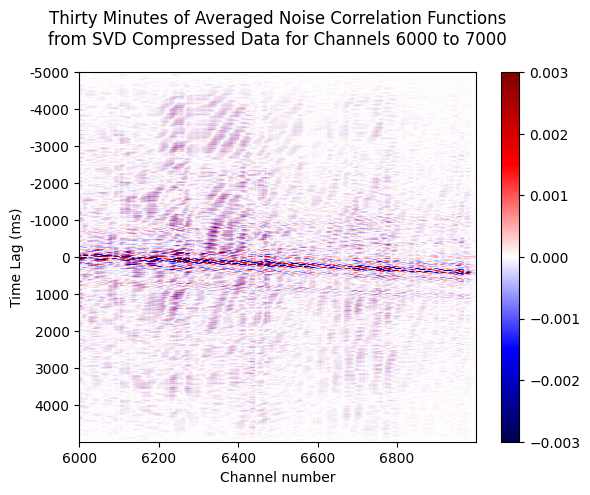

In [55]:
plt.clf()
vmax=np.percentile(np.absolute(svdxcorrs0[:,:]),30)
vmax = 0.003
plt.imshow(svdxcorrs[:,:]/6,aspect='auto',vmin=-vmax, vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('Thirty Minutes of Averaged Noise Correlation Functions\nfrom SVD Compressed Data for Channels 6000 to 7000',pad=20)
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.yticks(np.arange(0, 10000,step = 1000), labels=np.arange(-5000, 5000, step=1000))
plt.ylabel('Time Lag (ms)')
plt.xlabel('Channel number')

Text(0.5, 0, 'Channel number')

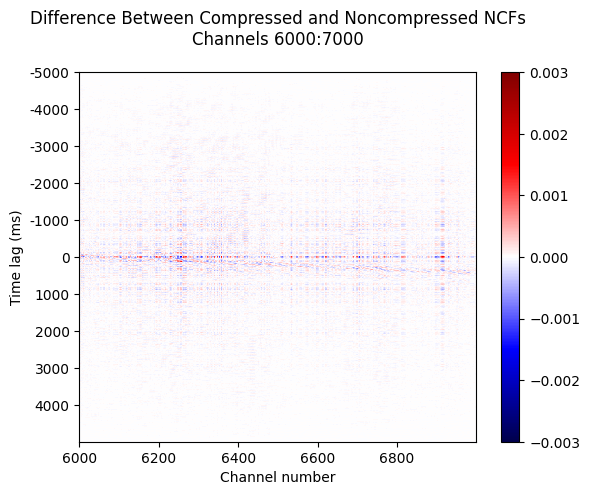

In [57]:
diff0 = svdxcorrs-xcorrs
# vmax=np.percentile(np.absolute(diff0[:,:]),30)
vmax = 0.003
plt.imshow(diff0[:,:]/6,aspect='auto',vmin=-vmax, vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('Difference Between Compressed and Noncompressed NCFs\nChannels 6000:7000',pad=20)
plt.xticks(np.arange(0, 1000,step = 200), labels=np.arange(6000, 7000, step=200))
plt.yticks(np.arange(0, 10000,step = 1000), labels=np.arange(-5000, 5000, step=1000))
plt.ylabel('Time lag (ms)')
plt.xlabel('Channel number')

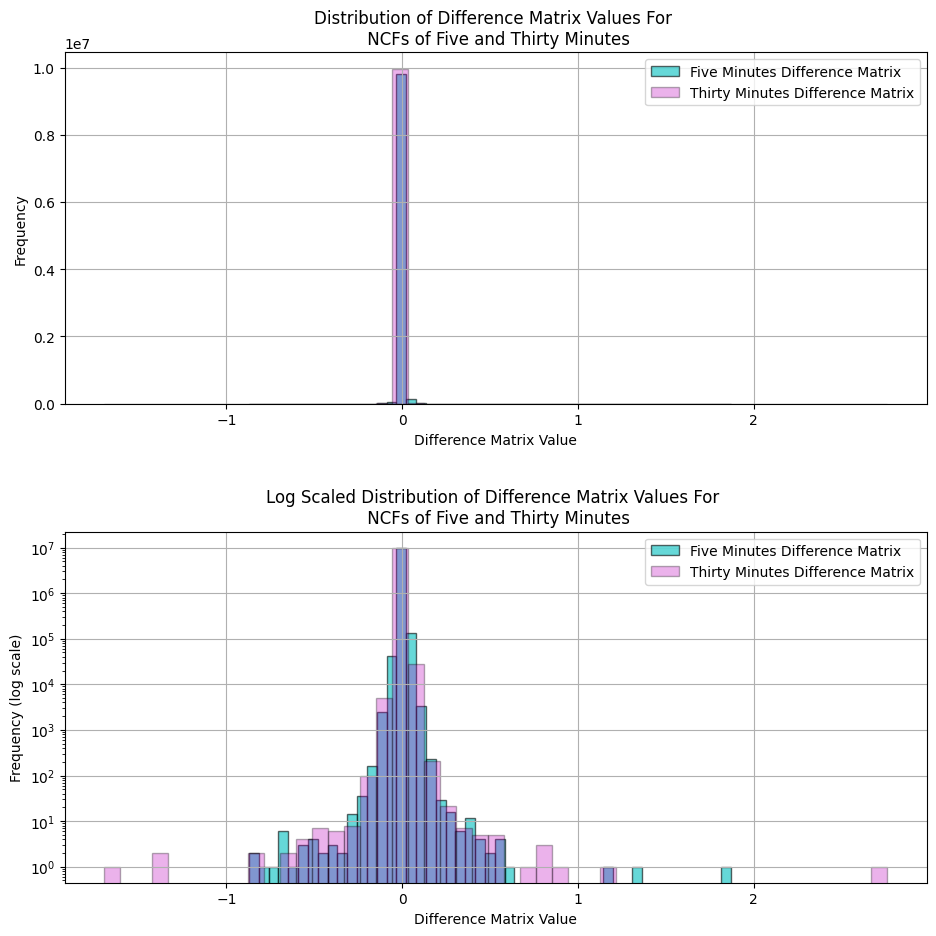

In [21]:
diff0 = xcorrs0-svdxcorrs0
values0 = diff0.flatten()
diff = (xcorrs - svdxcorrs)/6
values = diff.flatten()
bins0 = np.linspace(values0.min(), values0.max(), 50)  # 50 evenly spaced bins
bins = np.linspace(values.min(), values.max(),50)

import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # figsize is optional

axes[0].hist(values0, bins=bins0, color='c', edgecolor='black',alpha = 0.6, label='Five Minutes Difference Matrix')
axes[0].hist(values, bins=bins, color='m', edgecolor='black', alpha = 0.3,  label = 'Thirty Minutes Difference Matrix')
# axes[0].set_yscale('log')
axes[0].set_title("Distribution of Difference Matrix Values For \n NCFs of Five and Thirty Minutes")
axes[0].set_xlabel("Difference Matrix Value")
# axes[1,0].set_xticks()
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)
# axes[0].show()

axes[1].hist(values0, bins=bins0, color='c', edgecolor='black',alpha = 0.6, label='Five Minutes Difference Matrix')
axes[1].hist(values, bins=bins, color='m', edgecolor='black', alpha = 0.3,  label = 'Thirty Minutes Difference Matrix')
axes[1].set_yscale('log')
axes[1].set_title("Log Scaled Distribution of Difference Matrix Values For \n NCFs of Five and Thirty Minutes")
axes[1].set_xlabel("Difference Matrix Value")
# axes[1,0].set_xticks()
axes[1].set_ylabel("Frequency (log scale)")
axes[1].legend()
axes[1].grid(True)
# axes[1].show()
plt.tight_layout(pad=3.0) 


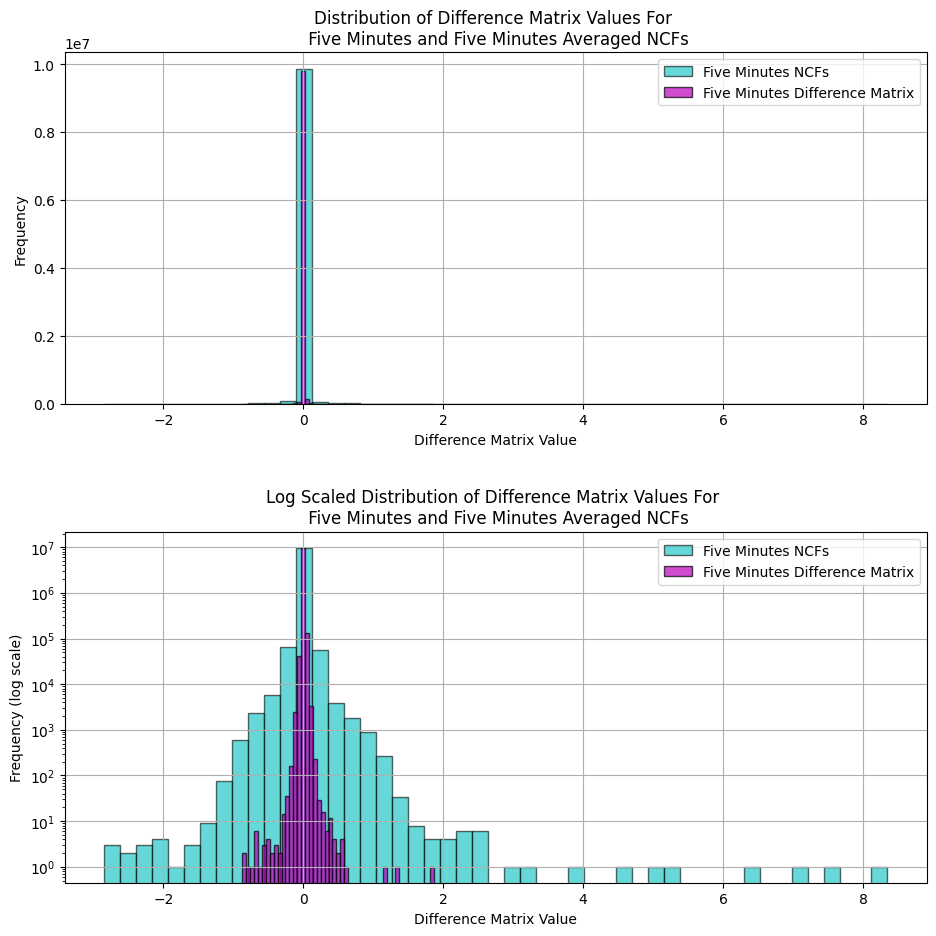

In [25]:
diff0 = xcorrs0-svdxcorrs0
values0 = diff0.flatten()
diff = xcorrs0
values = diff.flatten()
bins0 = np.linspace(values0.min(), values0.max(), 50)  # 50 evenly spaced bins
bins = np.linspace(values.min(), values.max(),50)

import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # figsize is optional

# axes[0].hist(values0, bins=bins0, color='c', edgecolor='black',alpha = 0.6, label='Five Minutes Difference Matrix')
axes[0].hist(values, bins=bins, color='c', edgecolor='black', alpha = 0.6,  label = 'Five Minutes NCFs')
axes[0].hist(values0, bins=bins0, color='m', edgecolor='black',alpha = 0.7, label='Five Minutes Difference Matrix')
# axes[0].set_yscale('log')
axes[0].set_title("Distribution of Difference Matrix Values For \n Five Minutes and Five Minutes Averaged NCFs")
axes[0].set_xlabel("Difference Matrix Value")
# axes[1,0].set_xticks()
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)
# axes[0].show()

axes[1].hist(values, bins=bins, color='c', edgecolor='black',alpha = 0.6, label='Five Minutes NCFs')
axes[1].hist(values0, bins=bins0, color='m', edgecolor='black', alpha = 0.7,  label = 'Five Minutes Difference Matrix')
axes[1].set_yscale('log')
axes[1].set_title("Log Scaled Distribution of Difference Matrix Values For \n Five Minutes and Five Minutes Averaged NCFs")
axes[1].set_xlabel("Difference Matrix Value")
# axes[1,0].set_xticks()
axes[1].set_ylabel("Frequency (log scale)")
axes[1].legend()
axes[1].grid(True)
# axes[1].show()
plt.tight_layout(pad=3.0) 


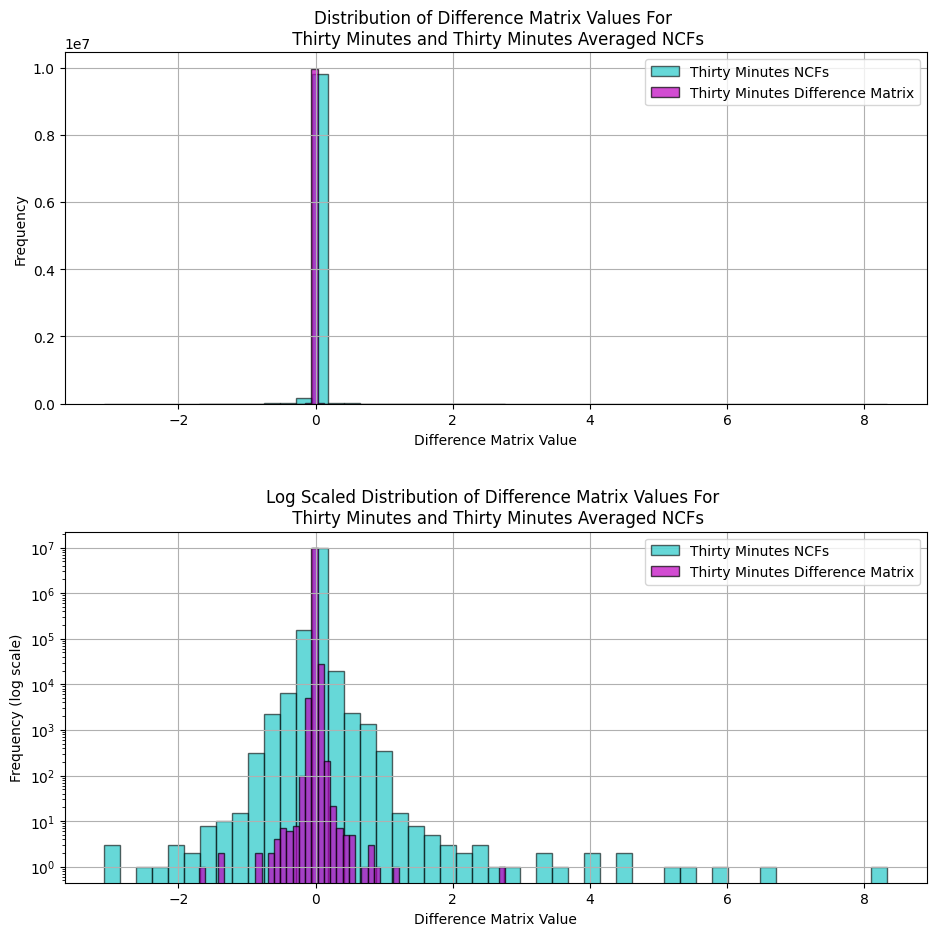

In [26]:
diff0 = (xcorrs-svdxcorrs)/6
values0 = diff0.flatten()
diff = xcorrs/6
values = diff.flatten()
bins0 = np.linspace(values0.min(), values0.max(), 50)  # 50 evenly spaced bins
bins = np.linspace(values.min(), values.max(),50)

import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # figsize is optional

# axes[0].hist(values0, bins=bins0, color='c', edgecolor='black',alpha = 0.6, label='Five Minutes Difference Matrix')
axes[0].hist(values, bins=bins, color='c', edgecolor='black', alpha = 0.6,  label = 'Thirty Minutes NCFs')
axes[0].hist(values0, bins=bins0, color='m', edgecolor='black',alpha = 0.7, label='Thirty Minutes Difference Matrix')
# axes[0].set_yscale('log')
axes[0].set_title("Distribution of Difference Matrix Values For \n Thirty Minutes and Thirty Minutes Averaged NCFs")
axes[0].set_xlabel("Difference Matrix Value")
# axes[1,0].set_xticks()
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)
# axes[0].show()

axes[1].hist(values, bins=bins, color='c', edgecolor='black',alpha = 0.6, label='Thirty Minutes NCFs')
axes[1].hist(values0, bins=bins0, color='m', edgecolor='black', alpha = 0.7,  label = 'Thirty Minutes Difference Matrix')
axes[1].set_yscale('log')
axes[1].set_title("Log Scaled Distribution of Difference Matrix Values For \n Thirty Minutes and Thirty Minutes Averaged NCFs")
axes[1].set_xlabel("Difference Matrix Value")
# axes[1,0].set_xticks()
axes[1].set_ylabel("Frequency (log scale)")
axes[1].legend()
axes[1].grid(True)
# axes[1].show()
plt.tight_layout(pad=3.0) 

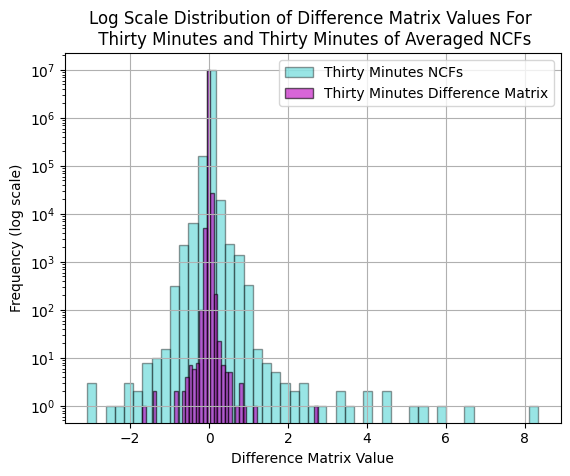

In [45]:
diff = (xcorrs-svdxcorrs)/6
diff = diff.flatten()
xcorrs_flat = (xcorrs/6).flatten()
bins0 = np.linspace(diff.min(), diff.max(), 50)  # 50 evenly spaced bins
bins = np.linspace(xcorrs_flat.min(), xcorrs_flat.max(),50)



plt.hist(xcorrs_flat, bins=bins, color='c',edgecolor = 'black',alpha = 0.4, label = 'Thirty Minutes NCFs')
plt.hist(diff, bins=bins0, color='m', edgecolor='black',alpha = 0.6,label='Thirty Minutes Difference Matrix')
plt.yscale('log')
plt.title("Log Scale Distribution of Difference Matrix Values For \n Thirty Minutes and Thirty Minutes of Averaged NCFs")
plt.xlabel("Difference Matrix Value")
plt.xticks()
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.grid(True)
plt.show()

In [75]:
magnitude_matrix = np.linalg.norm(xcorrs-svdxcorrs)
mag = np.linalg.norm(xcorrs5)
mag2 = np.linalg.norm(xcorrs)
mag3 = np.linalg.norm(xcorrs5-svdxcorrs5)
print(magnitude_matrix,mag,mag2,mag3)

162.3888206393625 114.06426383780492 642.148788400691 34.768341419877046


In [59]:
print("Min:", values.min())
print("Max:", values.max())
print("Unique values:", np.unique(values))

Min: -16.573493122759857
Max: 10.187052939430284
Unique values: [-16.57349312  -7.08917186  -5.14764251 ...   4.75456106   8.02915744
  10.18705294]


Text(0.5, 0, 'Channel')

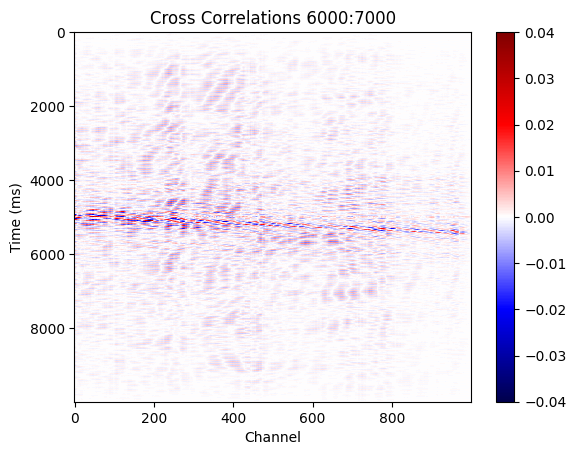

In [28]:
# vmax=np.percentile(np.absolute(xcorrs),50)
vmax = 0.04
plt.imshow(xcorrs,aspect='auto',vmin=-vmax, vmax=vmax,cmap='seismic')
plt.colorbar()
plt.title('Cross Correlations 6000:7000')
plt.ylabel('Time (ms)')
plt.xlabel('Channel')

In [34]:
r = np.corrcoef(xcorrs, svdxcorrs)[0, 1]
print(r)

-0.21557869212864333


In [14]:
xcorrs = xcorrs0+xcorrs1+xcorrs2+xcorrs3+xcorrs4+xcorrs5
svdxcorrs = svdxcorrs0+svdxcorrs1+svdxcorrs2+svdxcorrs3+svdxcorrs4+svdxcorrs5

In [16]:
# import numpy as np

A = xcorrs
Ak = svdxcorrs
fro_norm_diff = np.linalg.norm(A - Ak, ord='fro')
fro_norm_orig = np.linalg.norm(A, ord='fro')

relative_error = fro_norm_diff / fro_norm_orig
print(f"Relative Frobenius norm error: {relative_error}")

Relative Frobenius norm error: 0.17958507970886964


In [42]:
# Error meansuremnts 
diff = xcorrs - svdxcorrs
relativeError = la.norm(diff,ord='fro')/la.norm(xcorrs,ord='fro')
print(relativeError)
y_true = xcorrs
y_pred = svdxcorrs
correlation_matrix = np.corrcoef(y_true, y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(correlation_coefficient)
r_squared = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(r_squared)
print(rmse)
print(mae)

0.2520656068168853
-0.21557869212864333
0.9163766866309161
0.010293172062490571
0.007067604168281669


In [11]:
#r chosen above
num_rec = 1000
peak_timelag = np.empty((num_rec))
peak_timelag_postSVD = np.empty((num_rec))

for l in range(num_rec):
    peak_index = np.argmax(xcorrs[l,:])  # Get the index of the maximum value
    # peak_value = averaged_cross_correlation[l,:][peak_index]  # Maximum value
    peak_timelag[l] = peak_index

    peak_index_postSVD = np.argmax(svdxcorrs[l,:])  # Get the index of the maximum value
    # peak_value_postSVD = averaged_cross_correlation_postSVD[l,:][peak_index_postSVD]  # Maximum value
    peak_timelag_postSVD[l] = peak_index_postSVD

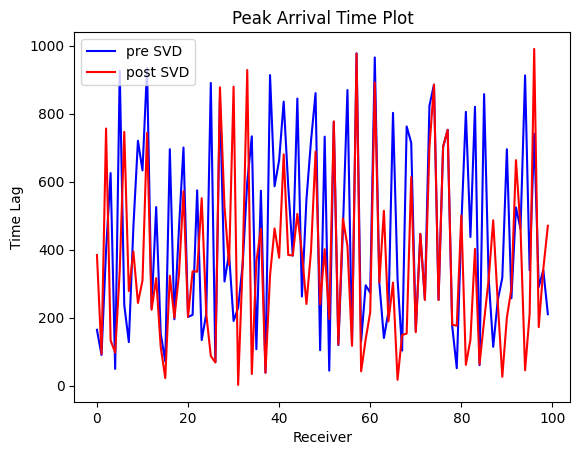

In [14]:
title = ('Peak Arrival Time Plot')
plt.plot(peak_timelag[20:120],label='pre SVD', color='blue')
plt.plot(peak_timelag_postSVD[20:120],label='post SVD', color='red')
plt.title(title)
plt.xlabel('Receiver')
plt.ylabel('Time Lag')
plt.legend()
plt.show()